In [1]:
%cd ..

/home/tianshu/prediction


In [2]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from jax import numpy as jnp
from jax import vmap

from forecast import Dataset, Results

In [3]:
ds = Dataset("data.npz", if_data="if.npz", offset=1000. * 1000.)
results = Results(
    ds, base_dir="results", manifest="results/manifest.json",
    baseline_key="Lr8")

  0%|          | 0/33 [00:00<?, ?it/s]

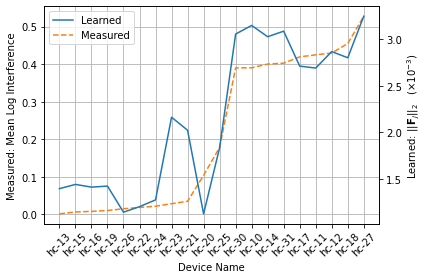

In [25]:
# Interference Magnitude
# L2 matrix norm is max_{m_i, m_k} m_i^TF_jm_k, i.e. the maximum possible
# interference achieved by a pair of modules in our embedding space.

def _interference_magnitude():

    def spectral_norm(v_s, v_g):
        return jnp.linalg.norm(jnp.matmul(v_s, v_g.T))

    vvv = vmap(vmap(vmap(spectral_norm)))
    res = np.load("results/Is1/0.9.npz")
    norms = jnp.mean(vvv(res["V_s"], res["V_g"]), axis=(0, 1))

    df = pd.read_csv("data/if.csv")
    mean_interference = np.array(df.groupby("runtime")["diff"].mean())

    order = np.argsort(mean_interference)

    fig, ax2 = plt.subplots(1, 1, figsize=(6, 4))

    ln2 = ax2.plot(
        mean_interference[order], '--', color='C1', label="Measured")
    ax2.set_ylabel("Measured: Mean Log Interference")
    ax2.set_xticks(np.arange(len(ds.runtimes)))
    ax2.set_xticklabels(ds.runtimes[order], rotation=45)
    ax2.grid()
    ax2.set_xlabel("Device Name")

    ax1 = ax2.twinx()
    ln1 = ax1.plot(norms[order] * 10**3, color='C0', label="Learned")
    ax1.set_ylabel(r"Learned: $||\mathbf{F}_j||_2 \quad (\times 10^{-3})$")

    ax1.legend(ln1 + ln2, [l.get_label() for l in ln1 + ln2])
    fig.savefig("figures/interference_interp_line.png", dpi=300)

_interference_magnitude()

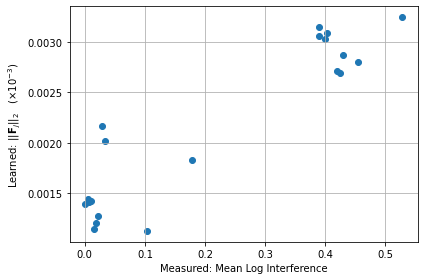

In [4]:
# Interference Magnitude
# L2 matrix norm is max_{m_i, m_k} m_i^TF_jm_k, i.e. the maximum possible
# interference achieved by a pair of modules in our embedding space.

def _interference_magnitude():

    def spectral_norm(v_s, v_g):
        return jnp.linalg.norm(jnp.matmul(v_s, v_g.T))

    vvv = vmap(vmap(vmap(spectral_norm)))
    res = np.load("results/Is1/0.9.npz")
    norms = jnp.mean(vvv(res["V_s"], res["V_g"]), axis=(0, 1))

    df = pd.read_csv("data/if.csv")
    mean_interference = np.array(df.groupby("runtime")["diff"].mean())

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.scatter(mean_interference, norms)
    ax.set_ylabel(r"Learned: $||\mathbf{F}_j||_2 \quad (\times 10^{-3})$")
    ax.set_xlabel("Measured: Mean Log Interference")
    ax.grid(visible=True)
    fig.tight_layout()
    fig.savefig("figures/interference_interp.png", dpi=300)

_interference_magnitude()

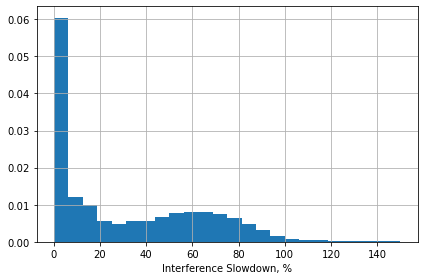

In [5]:
# Interference Histogram

def _interference_histogram():
    df = pd.read_csv("data/if.csv")
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.hist(
        100 * (np.exp(df["diff"]) - 1),
        bins=np.linspace(0, 150, 25), density=True)
    ax.set_xlabel("Interference Slowdown, %")
    ax.grid()
    fig.tight_layout()
    fig.savefig("figures/interference_hist.png", dpi=300)

_interference_histogram()

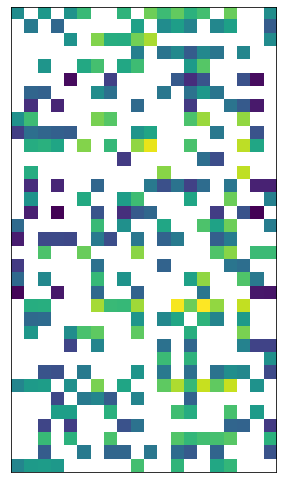

In [6]:
# Matrix Completion

def _matrix_completion():
    ds = Dataset("data/data.npz", if_data="data/if.npz", offset=1000. * 1000.)

    mat = ds.matrix[30:65]
    random_mask = np.random.rand(*mat.shape) > 0.4
    mat = np.ma.masked_where(random_mask == 1, mat)
    cmap = matplotlib.cm.viridis.copy()
    cmap.set_bad(color='white')

    fig, axs = plt.subplots(1, 1, figsize=(mat.shape[1] / 5, mat.shape[0] / 5))
    axs.imshow(mat, cmap=cmap)
    axs.set_xticks([])
    axs.set_yticks([])
    fig.tight_layout()
    fig.savefig("figures/matrix_completion.png", dpi=300, bbox_inches='tight')

_matrix_completion()

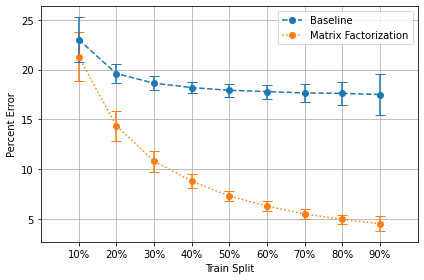

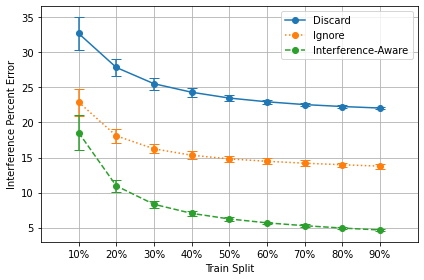

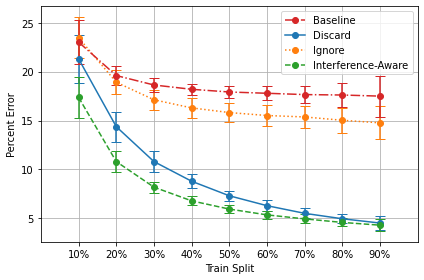

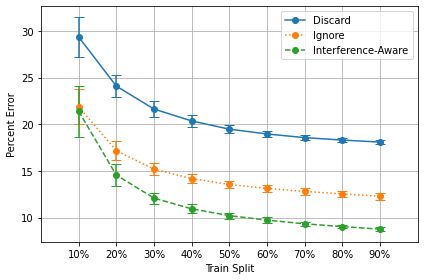

In [18]:
# Comparisons

def _method_comparisons():

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64"], ax=axs, boxplot=False, baseline=True,
        key="error", labels={"Er64": "Matrix Factorization"},
        fmt=["o:", "o--"])
    fig.tight_layout()
    fig.savefig("figures/non-interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "ignore", "Is1"], ax=axs, boxplot=False,
        baseline=False, key="interference", labels={
            "Er64": "Discard",
            "ignore": "Ignore",
            "Is1": "Interference-Aware"
        }, fmt=["o-", "o:", "o--"])
    axs.set_ylabel("Interference Percent Error")
    fig.tight_layout()
    fig.savefig("figures/interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "ignore", "Is1"], ax=axs, boxplot=False,
        baseline='C3', key="error", labels={
            "Er64": "Discard", "Is1": "Interference-Aware",
            "ignore": "Ignore"
        }, fmt=["o-", "o:", "o--", "o-."], colors=['C0', 'C1', 'C2', 'C3'])
    fig.tight_layout()
    fig.savefig("figures/interference_error.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["e.if3", "ig.if3", "if3"], ax=axs, boxplot=False,
        baseline=False, key="interference", labels={
            "e.if3": "Discard", "if3": "Interference-Aware",
            "ig.if3": "Ignore"
        }, fmt=["o-", "o:", "o--"], colors=['C0', 'C1', 'C2'])
    fig.tight_layout()
    fig.savefig("figures/interference_3way_main.png", dpi=300)

_method_comparisons()

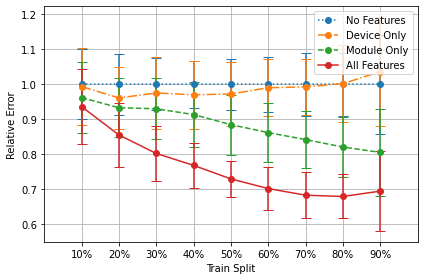

In [14]:
# Ablation: Input Features

def _ablation_features():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Lr64", "device_only", "module_only", "Er64"],
        ax=ax, baseline=False, key="error", boxplot=False, normalize="Lr64",
        fmt=["o:", "o-.", "o--", "o-"],
        labels={
            "Lr64": "No Features",
            "device_only": "Device Only",
            "module_only": "Module Only",
            "Er64": "All Features"
        })
    ax.set_ylabel("Relative Error")
    fig.tight_layout()
    fig.savefig("figures/feature_ablation.png", dpi=300)

_ablation_features()

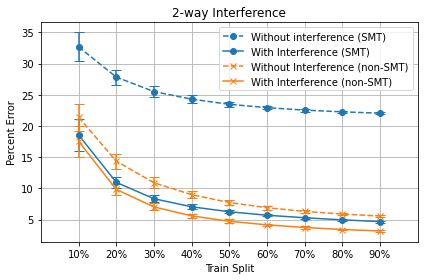

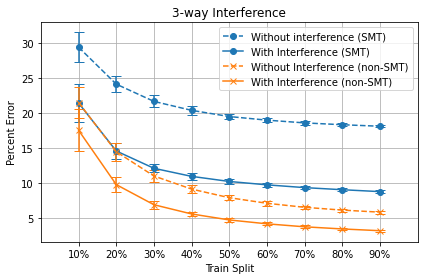

In [9]:
# 2-way, different datasets

def _interference_comparisons():
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["Er64", "Is1", "e.if.mc", "if.mc"], ax=ax, baseline=False,
        boxplot=False, key="interference", fmt=['o--', 'o-', 'x--', 'x-'],
        colors=['C0', 'C0', 'C1', 'C1'], labels={
            "Er64": "Without interference (SMT)",
            "Is1": "With Interference (SMT)",
            "e.if.mc": "Without Interference (non-SMT)",
            "if.mc": "With Interference (non-SMT)"
        })
    ax.set_title("2-way Interference")
    fig.tight_layout()
    fig.savefig("figures/interference_2way.png", dpi=300)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    results.plots(
        ["e.if3", "if3", "e.if3.mc", "if3.mc"], ax=ax, baseline=False,
        boxplot=False, key="interference", fmt=['o--', 'o-', 'x--', 'x-'],
        colors=['C0', 'C0', 'C1', 'C1'], labels={
            "e.if3": "Without interference (SMT)",
            "if3": "With Interference (SMT)",
            "e.if3.mc": "Without Interference (non-SMT)",
            "if3.mc": "With Interference (non-SMT)"
        })

    ax.set_title("3-way Interference")

    fig.tight_layout()
    fig.savefig("figures/interference_3way.png", dpi=300)

_interference_comparisons()

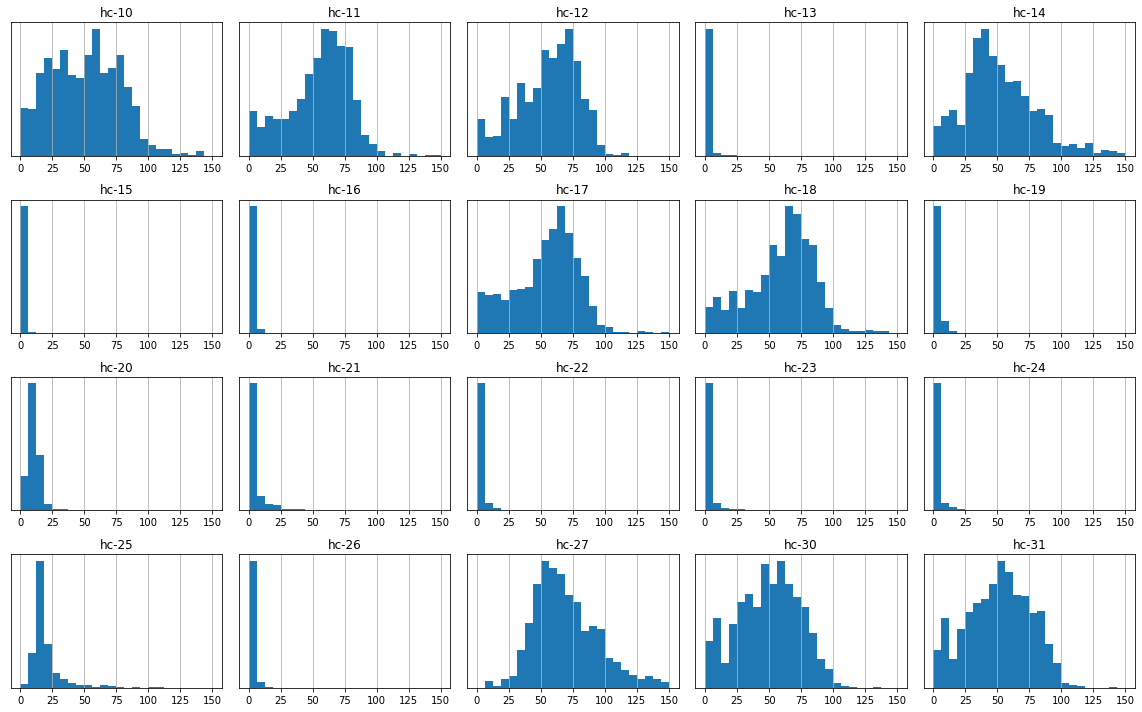

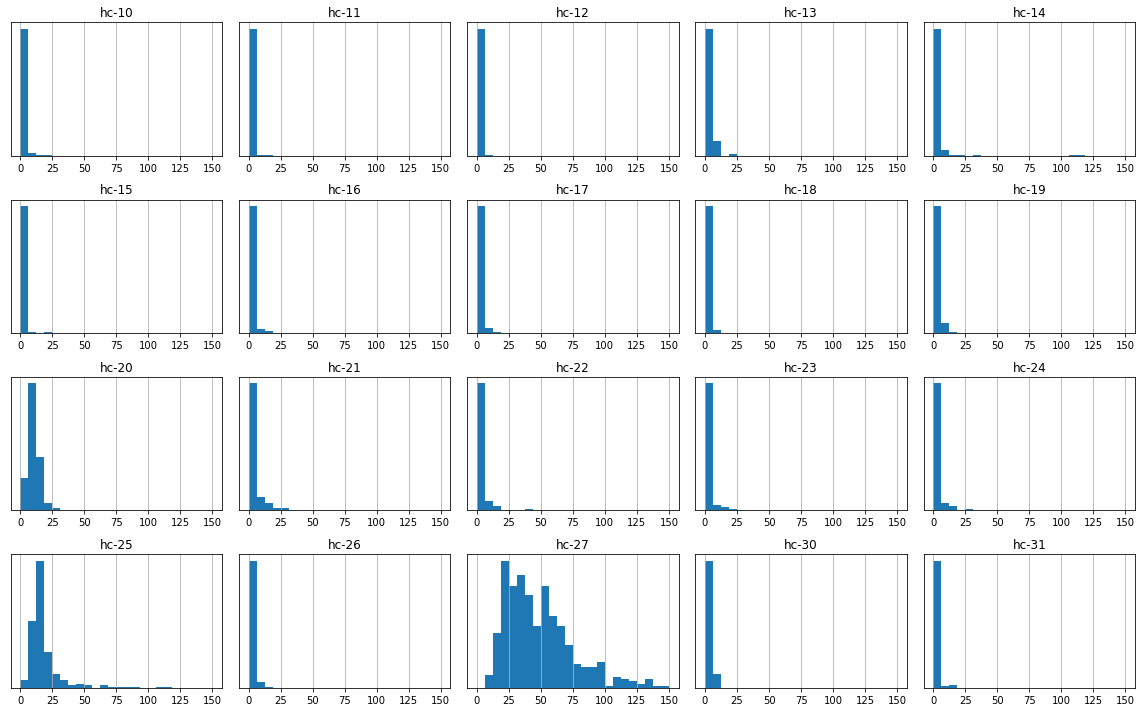

In [10]:
def _interference_runtime(data, out):
    fig, axs = plt.subplots(4, 5, figsize=(16, 10))
    df = pd.read_csv(data)

    for rt, ax in zip(ds.runtimes, axs.reshape(-1)):
        ax.hist(
            100 * (np.exp(df[df["runtime"] == rt]["diff"]) - 1),
            np.linspace(0, 150, 25), density=True)
        ax.set_yticks([])
        ax.set_title(rt)
        ax.grid()

    fig.tight_layout()
    fig.savefig(out, dpi=300, bbox_inches='tight')

_interference_runtime(
    "data/if.csv", "figures/interference_runtime.png")
_interference_runtime(
    "data/if.mc.csv", "figures/interference_multicore.png")